In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import cartopy.crs as ccrs
import gpflow
import tensorflow as tf
import glob
from utils_GP import *

will turn into GP2: March 2024, adding geodesic distance metric following geokernels base on (https://github.com/sigmaterra/geokernels) which is an implimentation for sklearn kernels.


In [97]:
def haversine_dist(X, X2):
    """
    Calculate the great-circle distance between two points on the Earth's surface.
    d = 2 * R * asin(sqrt(sin(Δlat/2)**2 + cose(lat1)*cos(lat2)*sin(Δlon/2)**2))    
    where:
    R is the earth's radius, 6371 km and Δlat and Δlon are the differences in latitude and longitude.
    Assumes 2D inputs, with columns [lat, lon] in degrees.
    """
    pi = np.pi / 180
    f = tf.expand_dims(X * pi, -2)  # ... x N x 1 x D
    f2 = tf.expand_dims(X2 * pi, -3)  # ... x 1 x M x D
    d = tf.sin((f - f2) / 2) ** 2
    lat1, lat2 = tf.expand_dims(X[:, 0] * pi, -1), \
                 tf.expand_dims(X2[:, 0] * pi, -2)
    cos_prod = tf.cos(lat2) * tf.cos(lat1)
    a = d[:,:,0] + cos_prod * d[:,:,1]
    c = tf.asin(tf.sqrt(a)) * 6371 * 2
    return c


class HaversineDistance(gpflow.kernels.Stationary):
    """
    Wrapper to use the haversine distance with any stationary kernel in GPflow.
    inspired from:
    https://stackoverflow.com/questions/59512401/custom-haversine-matern52-kernel-in-gpflow-2-0
    """
    def __init__(self, base: gpflow.kernels.Stationary):
        self.base = base

    @property
    def active_dims(self):
        return self.base.active_dims
    
    @property
    def variance(self):
        return self.base.variance
    
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        r = haversine_dist(X, X2) / self.base.lengthscales

        if hasattr(self.base, 'K_r'):
            return self.base.K_r(r)
        else:
            return self.base.K_r2(tf.square(r))



In [83]:
#test haversine distance calculation:

#make some random lat/lon points:
X = np.concatenate([np.linspace(-90,90,10)[:,None],np.linspace(-180,180,10)[:,None]],axis=1)
X2 = np.concatenate([np.random.uniform(-90,90,10)[:,None],np.random.uniform(-180,180,10)[:,None]],axis=1)
#does distance calculation work?
haversine_dist(X,X2)

<tf.Tensor: shape=(10, 10), dtype=float64, numpy=
array([[18589.37346235,   659.94377792, 13723.65330376,  3916.50097507,
         4566.05031827, 17442.01548735, 12122.50973329,  3772.09594506,
        13525.6777738 ,  1565.47633697],
       [16894.515583  ,  2029.96987984, 15752.35608411,  5846.7799998 ,
         6758.1879465 , 17148.89289805, 12799.79166906,  5937.73390807,
        13443.06765525,  1777.77213402],
       [15710.52094233,  3857.47448355, 17593.44995623,  6412.92978152,
         7975.3746796 , 17339.90696016, 10365.19529002,  8012.74142988,
        15731.13912442,  4753.38872652],
       [14449.38035038,  6036.09816611, 14479.39207113,  5700.42797613,
         7455.69364927, 15898.52054974,  6405.94390959,  8703.53189562,
        19418.24851461,  7791.85929301],
       [12542.35050082,  8522.72274986,  9780.94911698,  5416.41559271,
         6236.77589664, 12838.65057804,  3360.97214765,  8217.16770235,
        15766.80088393, 10450.26464969],
       [ 9938.40515411, 1

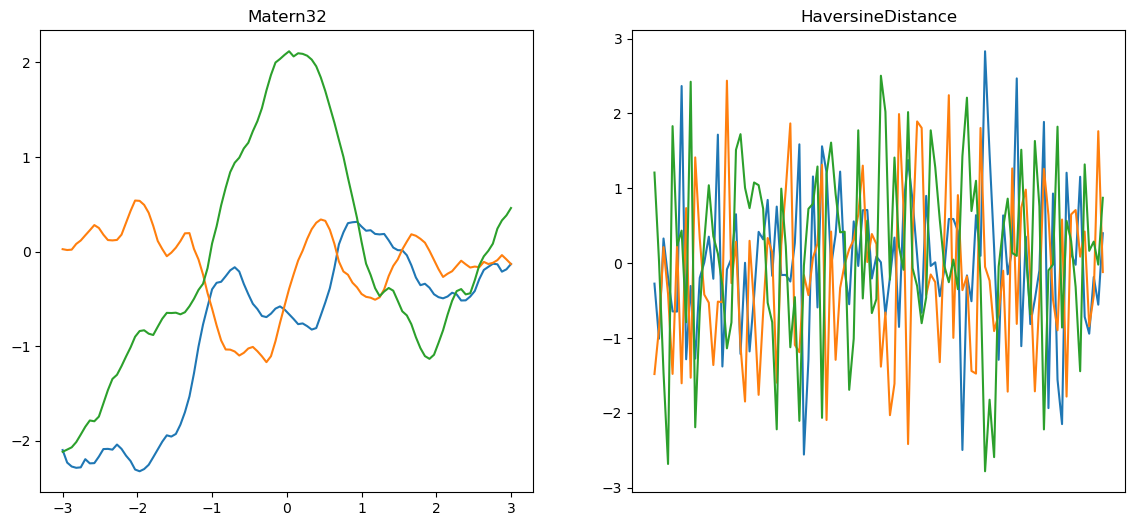

In [165]:
#plot regular kernel:
def plotkernelsample(k, ax, xmin=-3, xmax=3):
    xx = np.linspace(xmin, xmax, 100)[:, None]
    K = k(xx)
    ax.plot(xx, np.random.multivariate_normal(np.zeros(100), K, 3).T)
    ax.set_title(k.__class__.__name__)

#plot haversine version:
def plothaversinekernel(k, ax):
    X = np.concatenate([np.random.uniform(-90,90,100)[:,None],np.random.uniform(-180,180,100)[:,None]],axis=1)
    K = k(X,X)
    xx = np.linspace(-1, 1, 100)[:, None] #note this is just for plotting purposes, units are meaningless
    ax.plot(xx, np.random.multivariate_normal(np.zeros(100), K, 3).T)
    ax.set_title(k.__class__.__name__)
    ax.xaxis.set_visible(False)

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

plotkernelsample(gpflow.kernels.Matern32(), ax1)
plothaversinekernel(HaversineDistance(gpflow.kernels.Matern32(lengthscales=1000.0)), ax2)
#NOTE that setting the lengthscales for the Haversine kernel is important because the distance is in km! 
#Otherwise the kernel will be very small and the samples will be very small.
